# <div style="text-align: right"> Chapter __14__</div>

# __Pipes with magrittr__

In [1]:
# config
repr_html.tbl_df <- function(obj, ..., rows = 6) repr:::repr_html.data.frame(obj, ..., rows = rows)
options(dplyr.summarise.inform = FALSE)

In [2]:
library(magrittr)

First,
note that proactively worrying about memory is not a useful way to
spend your time: worry about it when it becomes a problem (i.e.,
you run out of memory), not before. Second, R isn’t stupid, and it
will share columns across data frames, where possible. Let’s take a
look at an actual data manipulation pipeline where we add a new
column to ggplot2::diamonds :

In [3]:
diamonds <- ggplot2::diamonds
diamonds2 <- diamonds %>%
    dplyr::mutate(price_per_carat = price / carat)

In [4]:
pryr::object_size(diamonds)

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp



3.46 MB

In [5]:
pryr::object_size(diamonds2)

3.89 MB

In [6]:
pryr::object_size(diamonds, diamonds2)

3.89 MB

`pryr::object_size()` gives the memory occupied by all of its argu‐
ments. The results seem counterintuitive at first:
* diamonds takes up 3.46 MB.
* diamonds2 takes up 3.89 MB.
* diamonds and diamonds2 together take up 3.89 MB!

How can that work? Well, `diamonds2` has 10 columns in common
with diamonds : there’s no need to duplicate all that data, so the two
data frames have variables in common. These variables will only get
copied if you modify one of them. In the following example, we
modify a single value in `diamonds$carat` . That means the carat
variable can no longer be shared between the two data frames, and a
copy must be made. The size of each data frame is unchanged, but
the collective size increases:

In [7]:
diamonds$carat[1] <- NA
pryr::object_size(diamonds)

3.46 MB

In [8]:
pryr::object_size(diamonds2)

3.89 MB

In [9]:
pryr::object_size(diamonds, diamonds2)

4.32 MB

(Note that we use `pryr::object_size()` here, not the built-in
`object.size()` . `object.size()` only takes a single object so it can’t
compute how data is shared across multiple objects.)

The pipe works by performing a “lexical transformation”: behind the
scenes,` magrittr` reassembles the code in the pipe to a form that
works by overwriting an intermediate object. When you run a pipe
like the preceding one, magrittr does something like this:

```r
my_pipe <- function(.) {
    . <- hop(., through = forest)
    . <- scoop(., up = field_mice)
    bop(., on = head)
}
my_pipe(foo_foo)
```

This means that the pipe won’t work for two classes of functions:

* Functions that use the current environment. For example,
`assign()` will create a new variable with the given name in the
current environment:

```r
assign('x', 10)
x
#> [1] 10

'x' %>% assign(100)
x
#> [1] 10
```

The use of assign with the pipe does not work because it
assigns it to a temporary environment used by %>% . If you do
want to use assign with the pipe, you must be explicit about the
environment:

In [13]:
env <- environment()
'x' %>%
    assign(100, envir = env)
x

[1] 100

Other functions with this problem include `get()` and load`()` .``

Functions that use lazy evaluation. In R, function arguments are
only computed when the function uses them, not prior to calling the function. The pipe computes each element in turn, so
you can’t rely on this behavior.
One place that this is a problem is `tryCatch()` , which lets you
capture and handle errors:

In [14]:
tryCatch(stop('!'), error = function(e) 'An error')

[1] "An error"

In [15]:
stop('!') %>%
    tryCatch(error = function(e) 'An error')

ERROR: Error in eval(lhs, parent, parent): !


## When not to use the Pipe
The pipe is a powerful tool, but it’s not the only tool at your disposal,
and it doesn’t solve every problem! Pipes are most useful for rewrit‐
ing a fairly short linear sequence of operations. I think you should
reach for another tool when:
* Your pipes are longer than (say) 10 steps. In that case, create
intermediate objects with meaningful names. That will make
debugging easier, because you can more easily check the inter‐
mediate results, and it makes it easier to understand your code,
because the variable names can help communicate intent.
* You have multiple inputs or outputs. If there isn’t one primary
object being transformed, but two or more objects being com‐
bined together, don’t use the pipe.
* You are starting to think about a directed graph with a complex
dependency structure. Pipes are fundamentally linear and
expressing complex relationships with them will typically yield
confusing code.

## Other Tools from magrittr
All packages in the tidyverse automatically make %>% available for
you, so you don’t normally load magrittr explicitly. However, there
are some other useful tools inside magrittr that you might want to
try out:
* When working with more complex pipes, it’s sometimes useful
to call a function for its side effects. Maybe you want to print
out the current object, or plot it, or save it to disk. Many times,
such functions don’t return anything, effectively terminating the
pipe.
To work around this problem, you can use the “tee” pipe. %T>%
works like %>% except that it returns the lefthand side instead of
the righthand side. It’s called “tee” because it’s like a literal T-
shaped pipe:

 NULL


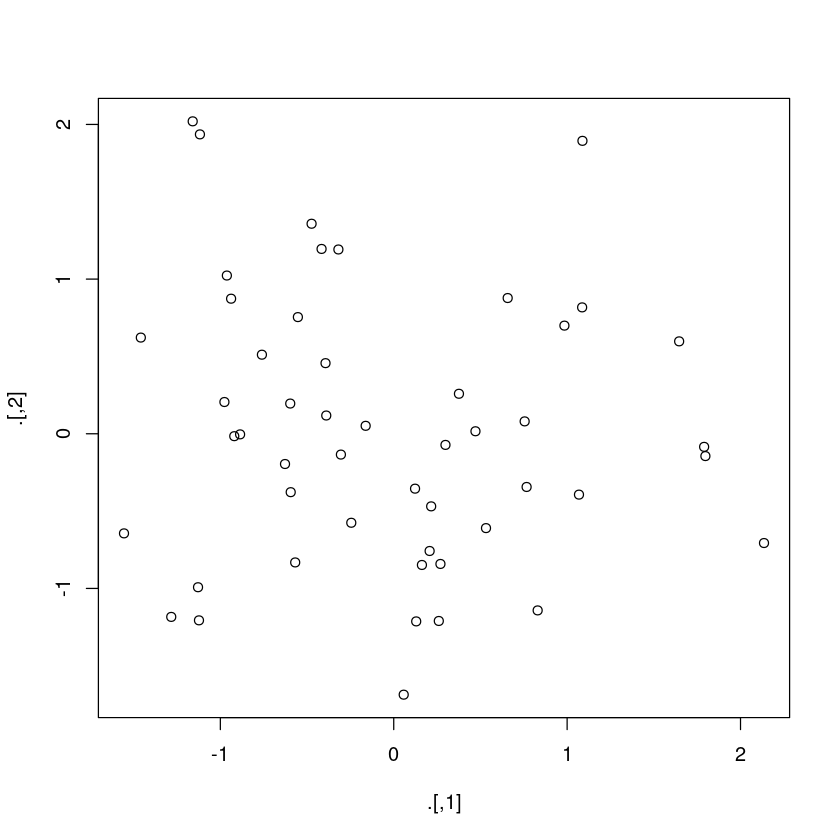

In [16]:
rnorm(100) %>%
    matrix(ncol = 2) %>%
    plot() %>%
    str()

 num [1:50, 1:2] -0.294 -0.035 0.23 -0.965 -0.32 ...


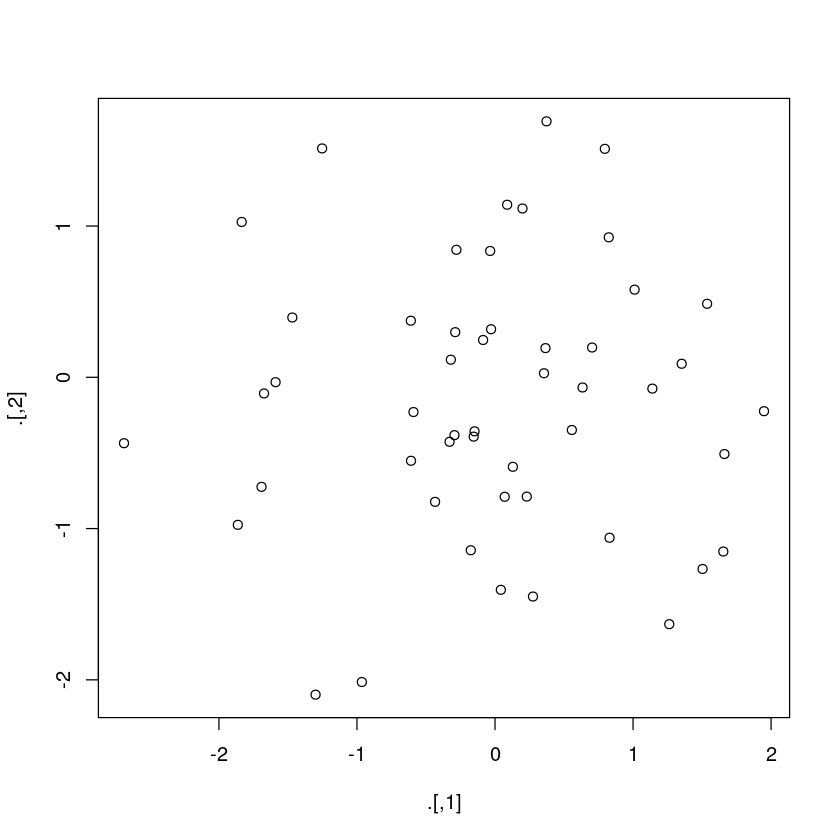

In [18]:
rnorm(100) %>%
    matrix(ncol = 2) %T>%
    plot() %>%
    str()

If you’re working with functions that don’t have a data frame–
based API (i.e., you pass them individual vectors, not a data
frame and expressions to be evaluated in the context of that data
frame), you might find %$% useful. It “explodes” out the variables
in a data frame so that you can refer to them explicitly. This is
useful when working with many functions in base R:

In [20]:
cor(mtcars$disp, mtcars$mpg)

[1] -0.8475514

In [21]:
mtcars %$%
    cor(disp, mpg)

[1] -0.8475514

In [22]:
mtcars %>%
    cor(disp, mpg)

ERROR: Error in pmatch(use, c("all.obs", "complete.obs", "pairwise.complete.obs", : object 'mpg' not found


For assignment magrittr provides the %<>% operator, which
allows you to replace code like:

In [23]:
mtcars <- mtcars %>%
    transform(cyl = cyl * 2)

In [24]:
# with
mtcars %<>% transform(cyl = cyl * 2)

I’m not a fan of this operator because I think assignment is such
a special operation that it should always be clear when it’s occurring. In my opinion, a little bit of duplication (i.e., repeating the
name of the object twice) is fine in return for making assignment more explicit.